In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud

# Downloading the stopwords from NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Majid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Majid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
hotel_reviews = pd.read_csv('hotel_reviews.csv')
hotel_reviews.head()

,Index,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text
0,0,Hotel The Pearl,"Paharganj, New Delhi",Jul-23,Best budget friendly hotel,9.0,Hotel the pearl is perfect place to stay in De...
1,1,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Amazing place,9.0,Location of the hotel is perfect. The hotel is...
2,2,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Overall good stay. Economic.,9.0,"Location, Indian food."
3,3,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Lovely,9.0,The location and the hotel itself is great. Ne...
4,4,Hotel The Pearl,"Paharganj, New Delhi",Aug-23,Great hotel Great staff and great staying,9.0,Friendly and smiling staffs.. The reception st...


Index: An identifier for each review.

Name: The name of the hotel.

Area: The area where the hotel is located.

Review_Date: The date when the review was posted.

Rating_attribute: A short description/title for the review.

Rating(Out of 10): The rating given by the user on a scale of 1 to 10.

Review_Text: The detailed review text.

## Data Cleaning and Type Conversion

In [27]:
hotel_reviews['Review_Date'] = pd.to_datetime(hotel_reviews['Review_Date'], errors='coerce', format='%b-%y')
hotel_reviews['Review_Date'].head()

0   2023-07-01
1   2023-08-01
2   2023-08-01
3   2023-08-01
4   2023-08-01
Name: Review_Date, dtype: datetime64[ns]

In [28]:
# Check for any duplicated rows
duplicated_rows = hotel_reviews.duplicated()
duplicated_rows.sum()

0

In [29]:
invalid_ratings = hotel_reviews['Rating(Out of 10)'][(hotel_reviews['Rating(Out of 10)'] < 0) | (hotel_reviews['Rating(Out of 10)'] > 10)]
invalid_ratings.count()

0

In [30]:
missing_values= hotel_reviews.isnull().sum()
missing_values

Index                0
Name                 0
Area                 0
Review_Date          0
Rating_attribute     0
Rating(Out of 10)    0
Review_Text          7
dtype: int64

In [31]:
#drop missing values
hotel_reviews.dropna(subset=['Review_Text'], inplace=True)

missing_values

Index                0
Name                 0
Area                 0
Review_Date          0
Rating_attribute     0
Rating(Out of 10)    0
Review_Text          7
dtype: int64

In [32]:
data_types = hotel_reviews.dtypes
data_types

Index                         int64
Name                         object
Area                         object
Review_Date          datetime64[ns]
Rating_attribute             object
Rating(Out of 10)           float64
Review_Text                  object
dtype: object

In [33]:
# Check the number of remaining rows
remaining_rows = hotel_reviews.shape[0]
remaining_rows

6994

In [34]:
# Feature Transformation: Extract year and month from 'Review_Date'
hotel_reviews['Review_Year'] = hotel_reviews['Review_Date'].dt.year
hotel_reviews['Review_Month'] = hotel_reviews['Review_Date'].dt.month
hotel_reviews.head()

,Index,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text,Review_Year,Review_Month
0,0,Hotel The Pearl,"Paharganj, New Delhi",2023-07-01,Best budget friendly hotel,9.0,Hotel the pearl is perfect place to stay in De...,2023,7
1,1,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Amazing place,9.0,Location of the hotel is perfect. The hotel is...,2023,8
2,2,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Overall good stay. Economic.,9.0,"Location, Indian food.",2023,8
3,3,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Lovely,9.0,The location and the hotel itself is great. Ne...,2023,8
4,4,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Great hotel Great staff and great staying,9.0,Friendly and smiling staffs.. The reception st...,2023,8


Exploratory Data Analysis (EDA):

In [35]:
# Descriptive Statistics

# Summary statistics for numerical columns
summary_statistics = hotel_reviews.describe(include=[float, int])
summary_statistics


,Index,Rating(Out of 10),Review_Year,Review_Month
count,6994.000000,6994.000000,6994.000000,6994.000000
mean,3499.709322,7.033729,2022.760366,6.298113
std,2021.465055,2.881802,0.525943,2.505234
min,0.000000,1.000000,2020.000000,1.000000
25%,1749.250000,6.000000,2023.000000,5.000000
50%,3498.500000,8.000000,2023.000000,7.000000
75%,5251.750000,9.000000,2023.000000,8.000000
max,7000.000000,10.000000,2023.000000,12.000000


Numerical Columns:
    Index: Ranges from 0 to 7000, which seems to be just a unique identifier for each review.
    
Rating(Out of 10):
Ranges from 1 to 10.

The mean rating is approximately 7.03, indicating a generally positive trend in the reviews.

The standard deviation is approximately 2.88, showing a moderate spread of ratings.

Review_Year:
Ranges from 2020 to 2023, indicating that the dataset contains reviews from these years.

Review_Month:
Ranges from 1 to 12, representing all months in a year.

In [36]:
#Distribution of ratings
rating_distribution = hotel_reviews['Rating(Out of 10)'].value_counts(normalize=True).sort_index()
rating_distribution

Rating(Out of 10)
1.0     0.123534
2.0     0.016872
2.5     0.000286
3.0     0.017729
4.0     0.019016
5.0     0.045754
6.0     0.070203
7.0     0.136832
7.9     0.000143
8.0     0.194452
9.0     0.169860
10.0    0.205319
Name: proportion, dtype: float64

Rating Distribution:
The ratings are skewed towards the higher end, with the majority of ratings being 8, 9, or 10.
The lowest ratings (1 and 2) make up a smaller portion of the dataset.

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\2847970913.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




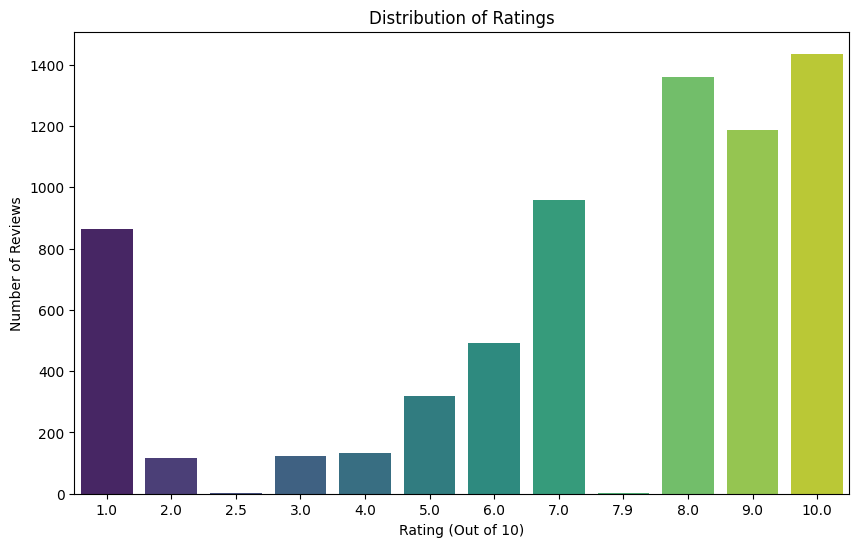

In [37]:
# 1. Rating Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating(Out of 10)', data=hotel_reviews, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating (Out of 10)')
plt.ylabel('Number of Reviews')
plt.show()


The majority of reviews have high ratings, especially 8, 9, and 10, indicating overall positive experiences.
There are relatively few reviews with low ratings (1 and 2).
The distribution is skewed towards the higher end, reflecting a tendency of guests to leave positive reviews.

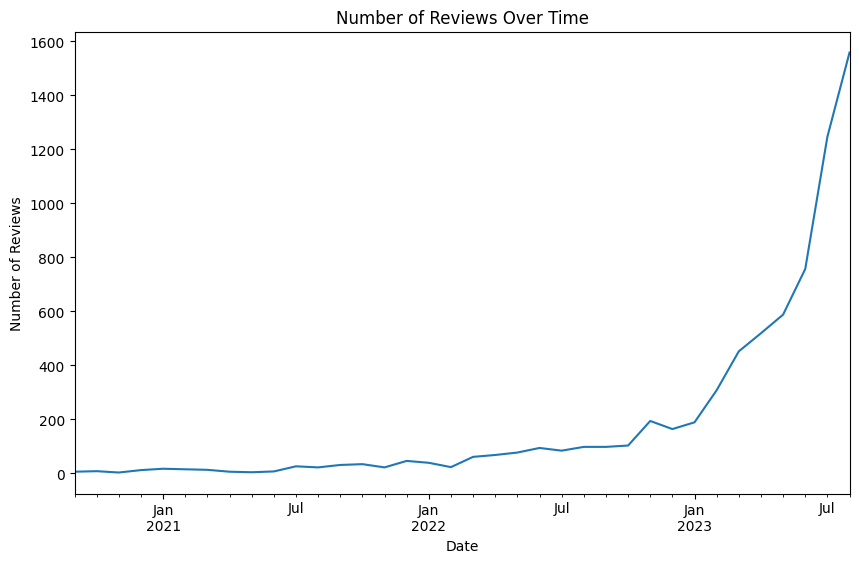

In [38]:
#Number of reviews over time
plt.figure(figsize=(10, 6))
hotel_reviews.set_index('Review_Date').resample('M').size().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

There is a noticeable trend of increasing activity over time, with more reviews being posted in recent months.
There are fluctuations in the number of reviews from month to month, which could be due to seasonal variations or specific events.

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\681622217.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




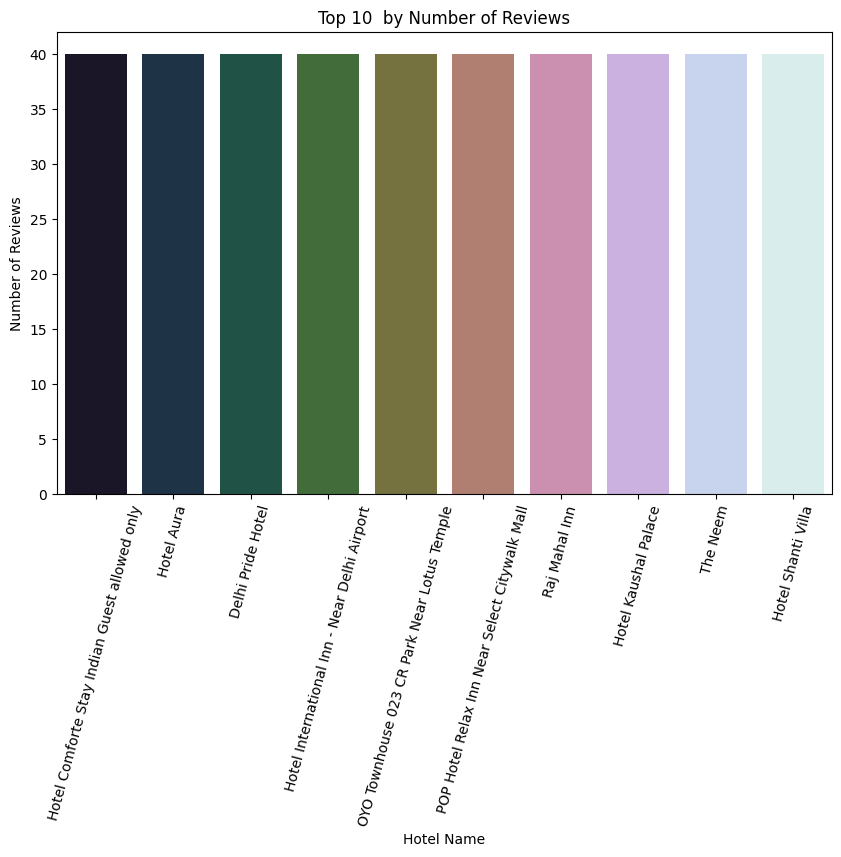

In [39]:
#Reviwes to hotels
top_hotels= hotel_reviews["Name"].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_hotels.index, y=top_hotels.values, palette="cubehelix")
plt.title('Top 10  by Number of Reviews')
plt.xlabel('Hotel Name')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=75)
plt.show()

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\1743108804.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




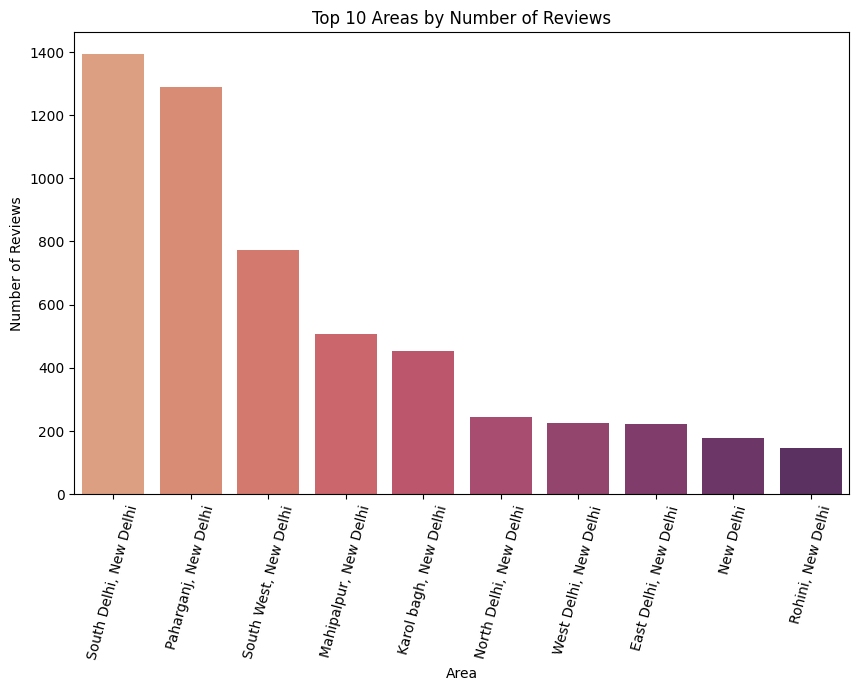

In [40]:
#4. Reviews by Area
top_areas = hotel_reviews['Area'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_areas.index, y=top_areas.values, palette='flare')
plt.title('Top 10 Areas by Number of Reviews')
plt.xlabel('Area')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=75)
plt.show()


There are noticeable differences in the number of reviews across different areas, indicating varying levels of guest activity or hotel concentration.
Some areas have significantly more reviews than others, suggesting they might be popular tourist destinations or have a higher density of hotels.

## Data Preprocessing:

In [41]:
lemmatizer = WordNetLemmatizer()

In [42]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stop words
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back to string
    text = ' '.join(words)
    
    return text

In [43]:
# Applying the text cleaning function to the review texts
hotel_reviews['Cleaned_Review_Text'] = hotel_reviews['Review_Text'].apply(clean_text)
hotel_reviews[['Review_Text', 'Cleaned_Review_Text']].head()

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\1481366975.py:6: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



,Review_Text,Cleaned_Review_Text
0,Hotel the pearl is perfect place to stay in De...,hotel pearl perfect place stay delhi paharganj...
1,Location of the hotel is perfect. The hotel is...,location hotel perfect hotel peaceful nice sta...
2,"Location, Indian food.",location indian food
3,The location and the hotel itself is great. Ne...,location hotel great next time stay nice room ...
4,Friendly and smiling staffs.. The reception st...,friendly smiling staff reception staff excelle...


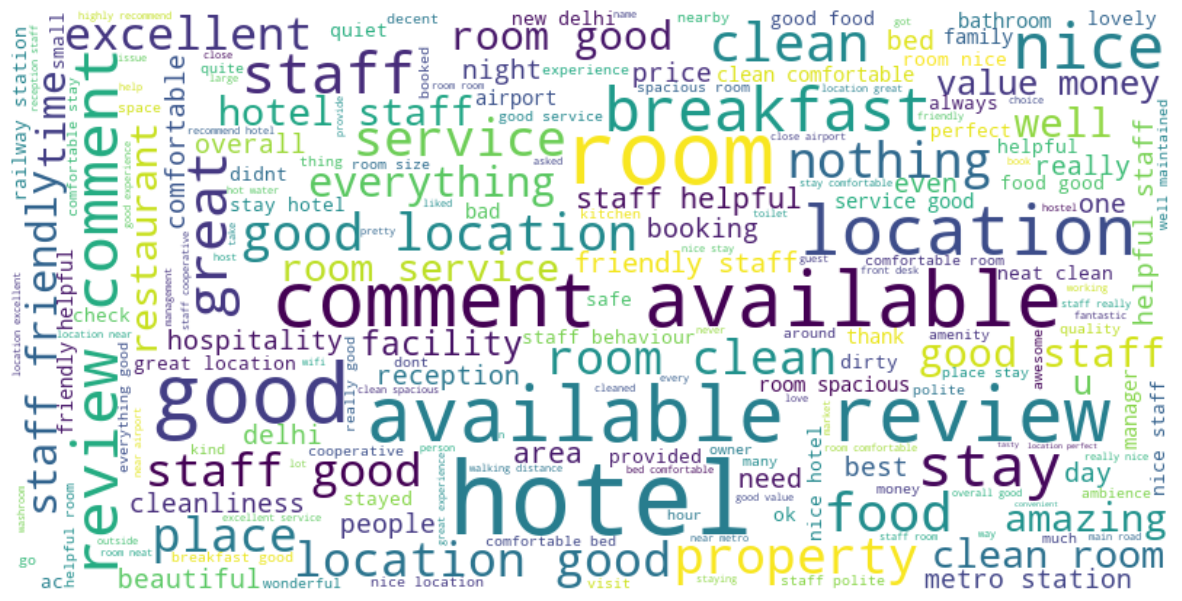

In [44]:
wordcloud = WordCloud(width = 800, height = 400, random_state=21, max_font_size=70, background_color='white').generate(' '.join(hotel_reviews['Cleaned_Review_Text']))

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [45]:
def tokenize(text):
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-Z]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

In [46]:
# tokenize data
hotel_reviews["tokenized_review"] = hotel_reviews.Review_Text.apply(lambda x: tokenize(x))
# calculate token count for any sent
hotel_reviews["sent_token_length"] = hotel_reviews["tokenized_review"].apply(lambda x: len(x.split()))

In [47]:
import plotly.express as px
fig = px.histogram(hotel_reviews, x="sent_token_length", nbins=20, color_discrete_sequence=["orange", "blue", "green"], barmode='group', histnorm="percent")
fig.show()

In [48]:
from transformers import pipeline

classifier= pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

C:\Users\Majid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [49]:
review_text= "The hotel was great! The room was clean and the staff were very friendly."   

In [50]:
result= classifier(review_text)
result

[{'label': '5 stars', 'score': 0.7743716835975647}]

Label: '5 stars' suggests that the model has predicted a very positive sentiment for this review. This is consistent with the content of the review, which includes positive words like "great," "clean," and "very friendly."

Score: The score of 0.7744 represents the model's confidence in its prediction. In this context, it means the model is fairly confident (but not absolutely certain) that the review corresponds to a '5 stars' rating.

In [51]:
def get_sentiment(review):
    try:
        result = classifier(review)
        return result[0]['label'], result[0]['score']
    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [52]:
hotel_reviews['Sentiment_Label'], hotel_reviews['Sentiment_Score'] = zip(*hotel_reviews['Cleaned_Review_Text'].map(get_sentiment))

In [53]:
hotel_reviews

,Index,Name,Area,Review_Date,Rating_attribute,Rating(Out of 10),Review_Text,Review_Year,Review_Month,Cleaned_Review_Text,tokenized_review,sent_token_length,Sentiment_Label,Sentiment_Score
0,0,Hotel The Pearl,"Paharganj, New Delhi",2023-07-01,Best budget friendly hotel,9.0,Hotel the pearl is perfect place to stay in De...,2023,7,hotel pearl perfect place stay delhi paharganj...,Hotel the pearl is perfect place to stay in De...,48,5 stars,0.765263
1,1,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Amazing place,9.0,Location of the hotel is perfect. The hotel is...,2023,8,location hotel perfect hotel peaceful nice sta...,Location of the hotel is perfect . The hotel i...,29,5 stars,0.616703
2,2,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Overall good stay. Economic.,9.0,"Location, Indian food.",2023,8,location indian food,"Location , Indian food .",5,3 stars,0.277844
3,3,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Lovely,9.0,The location and the hotel itself is great. Ne...,2023,8,location hotel great next time stay nice room ...,The location and the hotel itself is great . N...,38,5 stars,0.460397
4,4,Hotel The Pearl,"Paharganj, New Delhi",2023-08-01,Great hotel Great staff and great staying,9.0,Friendly and smiling staffs.. The reception st...,2023,8,friendly smiling staff reception staff excelle...,Friendly and smiling staffs . . The reception ...,35,5 stars,0.677971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,6996,FabHotel F9 NSP,"North Delhi, New Delhi",2023-08-01,I'd like to thank Manager.,10.0,"The room was good, comfortable and aesthetic \...",2023,8,room good comfortable aesthetic hotel good loc...,"The room was good , comfortable and aesthetic ...",49,4 stars,0.600009
6997,6997,FabHotel F9 NSP,"North Delhi, New Delhi",2023-07-01,Superb,9.0,good hotel,2023,7,good hotel,good hotel,2,4 stars,0.501079
6998,6998,FabHotel F9 NSP,"North Delhi, New Delhi",2023-07-01,fabulous,10.0,good experience for me about hotel \nvery good...,2023,7,good experience hotel good staff well done foo...,good experience for me about hotel \n very goo...,24,5 stars,0.658578
6999,6999,FabHotel F9 NSP,"North Delhi, New Delhi",2023-06-01,well done,10.0,well done,2023,6,well done,well done,2,5 stars,0.576242


## Analyzing the Result

In [54]:
print(hotel_reviews['Sentiment_Label'].unique())


['5 stars' '3 stars' '4 stars' '1 star' '2 stars']


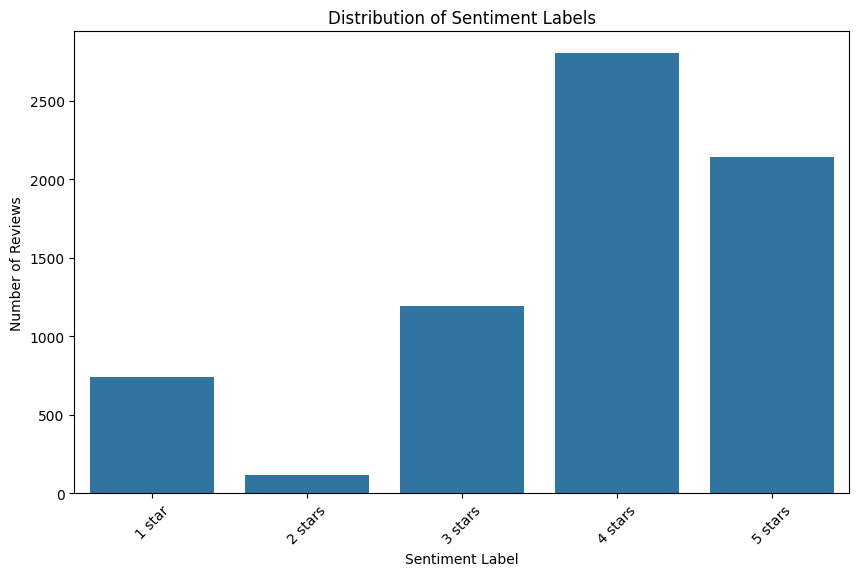

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(data=hotel_reviews, x='Sentiment_Label', order=sorted(hotel_reviews['Sentiment_Label'].unique()))
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

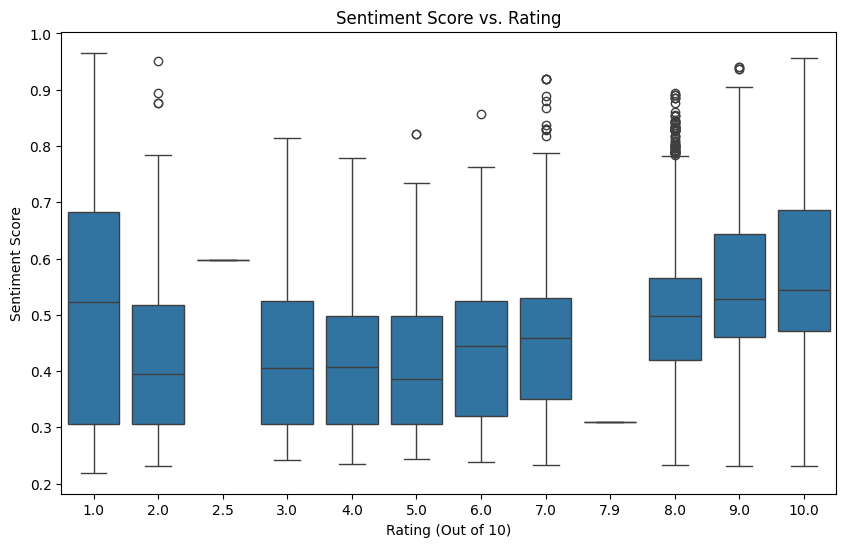

In [57]:
# Sentiment Score vs. Rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=hotel_reviews, x='Rating(Out of 10)', y='Sentiment_Score')
plt.title('Sentiment Score vs. Rating')
plt.xlabel('Rating (Out of 10)')
plt.ylabel('Sentiment Score')
plt.show()


In [61]:
# Average Sentiment Score by Hotel
avg_sentiment_hotel = hotel_reviews.groupby('Name')['Sentiment_Score'].mean().sort_values(ascending=False)
print(avg_sentiment_hotel.head(10))

Name
Bewafa Palace                                                    0.891549
The New Anand Near Karol Bagh Metro Station                      0.808818
OYO Townhouse 286 Near Kohat Enclave Metro Station               0.714017
OYO Hotel Shiv Shakti Inn Near Kamal Cinema                      0.711378
Flagship Sp Residency Near Sarita Vihar Metro Station            0.705097
Hotel Sky Inn - Safdarjung Enclave                               0.694423
Hotel Sky wood At Airport                                        0.692473
Roomshala 120 Hotel Crown Near Signature Bridge KHAJOORI KHAS    0.686280
Roomshala 069 Harshi Residency - Janankpuri                      0.679267
Hotel Park Suites at Airport                                     0.677089
Name: Sentiment_Score, dtype: float64


In [60]:
# Average Sentiment Score by Area
avg_sentiment_area = hotel_reviews.groupby('Area')['Sentiment_Score'].mean().sort_values(ascending=False)
print(avg_sentiment_area.head(10))


Area
North Delhi, New Delhi           0.549196
Safdarjung Enclave, New Delhi    0.537350
Central Delhi, New Delhi         0.534384
Rohini, New Delhi                0.532113
Sundar Nagar, New Delhi          0.528955
Nehru Place, New Delhi           0.525865
Greater Kailash 1, New Delhi     0.522218
Kailash Colony, New Delhi        0.520171
Saket, New Delhi                 0.519127
South West, New Delhi            0.517418
Name: Sentiment_Score, dtype: float64


In [65]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px

In [66]:
df = pd.read_csv('sentimental_hotel_review.csv')

In [72]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Hotel Reviews Dashboard"),
    
    dcc.Dropdown(
        id='hotel-dropdown',
        options=[{'label': hotel, 'value': hotel} for hotel in df['Name'].unique()],
        value=df['Name'].unique()[0],
        multi=True
    ),
    
    dcc.Graph(id='rating-distribution'),
    dcc.Graph(id='sentiment-score-distribution'),
    dcc.Graph(id='reviews-over-time'),
    dcc.Graph(id='avg-rating-per-hotel'),
    dcc.Graph(id='sentiment-distribution'),
    dcc.Graph(id='reviews-over-years')
])


# Define callback to update rating distribution graph
@app.callback(
    Output('rating-distribution', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def update_rating_distribution(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    fig = px.histogram(filtered_df, x='Rating(Out of 10)', nbins=10, title='Rating Distribution')
    return fig

# Define callback to update sentiment score distribution graph
@app.callback(
    Output('sentiment-score-distribution', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def update_sentiment_score_distribution(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    fig = px.histogram(filtered_df, x='Sentiment_Score', nbins=10, title='Sentiment Score Distribution')
    return fig

# Define callback to update reviews over time graph
@app.callback(
    Output('reviews-over-time', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def update_reviews_over_time(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    filtered_df['Review_Date'] = pd.to_datetime(filtered_df['Review_Date'])
    fig = px.line(filtered_df, x='Review_Date', y='Sentiment_Score', color='Name', title='Reviews Over Time')
    return fig
# Average Rating per Hotel
@app.callback(
    Output('avg-rating-per-hotel', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def avg_rating_per_hotel(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    avg_ratings = filtered_df.groupby('Name')['Rating(Out of 10)'].mean().reset_index()
    fig = px.bar(avg_ratings, x='Name', y='Rating(Out of 10)', title='Average Rating per Hotel')
    return fig

# Sentiment Distribution
@app.callback(
    Output('sentiment-distribution', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def sentiment_distribution(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    sentiment_counts = filtered_df['Sentiment_Label'].value_counts().reset_index()
    sentiment_counts.columns = ['Sentiment_Label', 'count']  # Rename columns for clarity
    fig = px.pie(sentiment_counts, names='Sentiment_Label', values='count', title='Sentiment Distribution')
    return fig

# Reviews over Years
@app.callback(
    Output('reviews-over-years', 'figure'),
    [Input('hotel-dropdown', 'value')]
)
def reviews_over_years(selected_hotels):
    if not isinstance(selected_hotels, list):
        selected_hotels = [selected_hotels]
    filtered_df = df[df['Name'].isin(selected_hotels)]
    fig = px.histogram(filtered_df, x='Review_Year', title='Distribution of Reviews Over Years')
    return fig


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\2826647248.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\2826647248.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Majid\AppData\Local\Temp\ipykernel_14284\2826647248.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa